In [1]:
!pip uninstall -y magent2

!pip install magent2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.9 MB/s eta 0:00:00


In [2]:
import torch

class Config:
    def __init__(self):
        # --- MAgent2 Environment Configuration (can be shared or adapted from IDQ) ---
        self.ENV_CONFIG = {
            "map_size": 45, # Example, adjust as needed
            "minimap_mode": False,
            "step_reward": 0.01, # QMIX often uses only the global reward at the end or for specific events
            "dead_penalty": -5, # Example
            "attack_penalty": -0.01, # Example
            "attack_opponent_reward": 5, # Example
            "max_cycles": 400, # This will be our episode_limit
            "extra_features": False, # Keep it simple for now
            "render_mode": "rgb_array", # "human" for visualization, "rgb_array" for training
        }

        # --- QMIX Hyperparameters ---
        self.GAMMA = 0.99
        self.LR_AGENT = 0.0005
        self.OPTIMIZER_EPS = 1e-8
        self.RNN_HIDDEN_DIM = 32
        self.QMIX_MIXING_EMBED_DIM = 32
        self.QMIX_HYPERNET_EMBED_DIM = 32
        self.BATCH_SIZE_EPISODES = 8
        self.GRAD_NORM_CLIP = 10
        self.TARGET_UPDATE_INTERVAL_EPISODES = 50
        self.MAX_BUFFER_SIZE_EPISODES = 50
        
        # --- Training Loop ---
        self.NUM_EPISODES_TOTAL = 100
        self.MIN_EPISODES_FOR_TRAINING = 1
        self.TRAIN_INTERVAL_EPISODES = 1
        self.MODEL_SAVE_INTERVAL_EPISODES = 1
        self.LOG_INTERVAL_EPISODES = 1

        # --- Epsilon-greedy Exploration ---
        self.EPS_START = 1.0
        self.EPS_END = 0.05
        self.EPS_DECAY_EPISODES = 100

        # --- Red Team Epsilon (if different) ---
        self.RED_EPS_START = 1.0
        self.RED_EPS_END = 0.05
        self.RED_EPS_DECAY_EPISODES = 100

        # --- Elo Configuration ---
        self.DEFAULT_ELO = 1200
        self.ELO_K_FACTOR = 32
        self.OPPONENT_POOL_MAX_SIZE = 20
        self.OPPONENT_SELECTION_STRATEGY = "random_weighted"
        self.OPPONENT_SWITCH_INTERVAL_EPISODES = 10

        # --- Miscellaneous ---
        self.SEED = 42
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        self.MODEL_SAVE_DIR = "QMIX/models"
        self.LOG_DIR = "QMIX/logs"

        self.TRAIN_TEAM_PREFIX = "blue"
        self.OPPONENT_TEAM_PREFIX = "red"


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNAgent(nn.Module):
    def __init__(self, input_shape, n_actions, rnn_hidden_dim):
        super(RNNAgent, self).__init__()
        self.n_actions = n_actions
        self.rnn_hidden_dim = rnn_hidden_dim

        # Giả sử input_shape là kích thước của output từ CNN (nếu có)
        # Hoặc kích thước của observation nếu không dùng CNN trước RNN
        # Ví dụ: nếu observation là (H, W, C) và bạn có CNN xử lý nó trước,
        # input_shape ở đây sẽ là số features sau khi flatten output của CNN.
        # Nếu không, input_shape là số features của observation đã được flatten.
        # Trong MAgent, observation thường là (map_size, map_size, num_feature_planes)
        # Chúng ta cần một CNN để xử lý nó trước.
        # Dựa trên IDQ/q_network.py, chúng ta có thể tái sử dụng phần CNN.

        # Phần CNN (tương tự IDQ/q_network.py)
        # input_shape ở đây là observation_shape (H, W, C)
        num_channels = input_shape[-1]
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1), # Thêm padding để giữ kích thước
            nn.ReLU(),
            nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Tính toán flatten_dim sau CNN
        _dummy_cnn_input_shape_chw = (input_shape[2], input_shape[0], input_shape[1])
        dummy_cnn_input_with_batch = torch.randn(1, *_dummy_cnn_input_shape_chw)
        dummy_cnn_output = self.cnn(dummy_cnn_input_with_batch)
        self.cnn_output_features = dummy_cnn_output.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.cnn_output_features, rnn_hidden_dim)
        self.rnn = nn.GRUCell(rnn_hidden_dim, rnn_hidden_dim)
        self.fc2 = nn.Linear(rnn_hidden_dim, n_actions)

    def init_hidden(self):
        # Tạo hidden state khởi tạo (batch_size, rnn_hidden_dim)
        return self.fc1.weight.new(1, self.rnn_hidden_dim).zero_()

    def forward(self, obs, hidden_state):
        # obs: (batch_size, H, W, C) hoặc (H, W, C)
        is_single_obs = False
        if obs.dim() == 3: # (H, W, C)
            is_single_obs = True
            obs = obs.unsqueeze(0) # (1, H, W, C)

        # Xử lý CNN
        # Input cho CNN cần là (B, C, H, W)
        # obs hiện tại là (B, H, W, C)
        # 1. torch.fliplr(obs): Flips the last dimension (C). Output: (B, H, W, C_flipped)
        # obs_temp_flipped_channels = torch.fliplr(obs) # Có thể không cần flip kênh cho QMIX
        # 2. .permute(0, 3, 1, 2): Original (B,H,W,C) -> New (B, C, H, W)
        obs_processed_for_cnn = obs.permute(0, 3, 1, 2)

        cnn_out = self.cnn(obs_processed_for_cnn) # (B, C_out, H_out, W_out)
        x_flattened = cnn_out.reshape(cnn_out.shape[0], -1) # (B, cnn_output_features)

        x = F.relu(self.fc1(x_flattened))
        h_in = hidden_state.reshape(-1, self.rnn_hidden_dim)
        h = self.rnn(x, h_in)
        q = self.fc2(h) # (B, n_actions)

        if is_single_obs:
            return q.squeeze(0), h.squeeze(0) # (n_actions,), (rnn_hidden_dim,)
        return q, h


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QMixer(nn.Module):
    def __init__(self, n_agents, state_shape, mixing_embed_dim, hypernet_embed=64):
        super(QMixer, self).__init__()

        self.n_agents = n_agents
        self.state_shape = state_shape # Kích thước của global state
        self.embed_dim = mixing_embed_dim # Kích thước của embedding layer trong mixing network

        # Hypernetwork để tạo weights cho mixing network layers
        # Layer 1
        self.hyper_w1 = nn.Sequential(
            nn.Linear(state_shape, hypernet_embed),
            nn.ReLU(),
            nn.Linear(hypernet_embed, n_agents * self.embed_dim)
        )
        # Bias cho layer 1
        self.hyper_b1 = nn.Linear(state_shape, self.embed_dim)

        # Layer 2
        self.hyper_w2 = nn.Sequential(
            nn.Linear(state_shape, hypernet_embed),
            nn.ReLU(),
            nn.Linear(hypernet_embed, self.embed_dim) # Output là vector embed_dim x 1
        )
        # Bias cho layer 2 (là một scalar)
        self.hyper_b2 = nn.Sequential(
            nn.Linear(state_shape, self.embed_dim), # Tạm thời để embed_dim, sau đó sẽ qua 1 linear nữa
            nn.ReLU(),
            nn.Linear(self.embed_dim, 1)
        )

    def forward(self, agent_qs, states):
        # agent_qs: (batch_size, n_agents) - Q-value của hành động được chọn bởi mỗi agent
        # states: (batch_size, state_shape) - Global state

        batch_size = agent_qs.size(0)
        agent_qs = agent_qs.view(batch_size, 1, self.n_agents) # (batch_size, 1, n_agents)

        # Layer 1
        w1 = torch.abs(self.hyper_w1(states)) # (batch_size, n_agents * embed_dim)
        w1 = w1.view(batch_size, self.n_agents, self.embed_dim) # (batch_size, n_agents, embed_dim)
        b1 = self.hyper_b1(states) # (batch_size, embed_dim)
        b1 = b1.view(batch_size, 1, self.embed_dim) # (batch_size, 1, embed_dim)

        # torch.bmm: batch matrix multiplication
        # (batch_size, 1, n_agents) @ (batch_size, n_agents, embed_dim) -> (batch_size, 1, embed_dim)
        hidden = F.elu(torch.bmm(agent_qs, w1) + b1) # (batch_size, 1, embed_dim)

        # Layer 2
        w2 = torch.abs(self.hyper_w2(states)) # (batch_size, embed_dim)
        w2 = w2.view(batch_size, self.embed_dim, 1) # (batch_size, embed_dim, 1)
        b2 = self.hyper_b2(states) # (batch_size, 1)
        b2 = b2.view(batch_size, 1, 1) # (batch_size, 1, 1)

        # (batch_size, 1, embed_dim) @ (batch_size, embed_dim, 1) -> (batch_size, 1, 1)
        q_total = torch.bmm(hidden, w2) + b2 # (batch_size, 1, 1)
        q_total = q_total.view(batch_size, -1) # (batch_size, 1)

        return q_total

In [5]:
import numpy as np
import random
from collections import deque
import torch # Needed for sample_batch if converting to tensors

class EpisodeBuffer:
    def __init__(self, buffer_size_episodes, episode_len_limit, n_agents, obs_shape, state_shape, action_shape, device):
        """
        buffer_size_episodes: Max number of episodes to store.
        episode_len_limit: Max length of an episode (max_cycles from env).
        n_agents: Number of agents in the team we are training.
        obs_shape: Shape of individual agent observation.
        state_shape: Shape of the global state.
        action_shape: Number of actions for an agent (scalar).
        """
        self.buffer_size_episodes = buffer_size_episodes
        self.episode_len_limit = episode_len_limit
        self.n_agents = n_agents
        self.obs_shape = obs_shape
        self.state_shape = state_shape
        self.action_shape = action_shape # This is n_actions
        self.device = device

        # Main storage for completed episodes
        self.episodes_storage = deque(maxlen=self.buffer_size_episodes)

        # Temporary buffers for the current episode being built
        self._reset_current_episode_buffers() # Initialize temp buffers
        self.current_episode_step = 0

    def _reset_current_episode_buffers(self):

        # Ensure obs_dims and state_dims are tuples for np.zeros
        obs_dims = self.obs_shape if isinstance(self.obs_shape, tuple) else (self.obs_shape,)
        state_dims = self.state_shape if isinstance(self.state_shape, tuple) else (self.state_shape,)

        self.temp_obs_n = np.zeros((self.episode_len_limit, self.n_agents, *obs_dims), dtype=np.float32)
        self.temp_state = np.zeros((self.episode_len_limit, *state_dims), dtype=np.float32)
        self.temp_actions = np.zeros((self.episode_len_limit, self.n_agents, self.action_shape), dtype=np.int64)
        self.temp_reward = np.zeros((self.episode_len_limit, 1), dtype=np.float32)
        self.temp_terminated = np.zeros((self.episode_len_limit, 1), dtype=np.bool_)
        self.temp_filled_mask = np.zeros((self.episode_len_limit, 1), dtype=np.bool_) # For QMIX, indicates valid steps

    def start_new_episode(self):
        if self.current_episode_step > 0:
            # Commit the previously built episode
            episode_data = {
                'obs_n': self.temp_obs_n[:self.current_episode_step].copy(),
                'state': self.temp_state[:self.current_episode_step].copy(),
                'actions': self.temp_actions[:self.current_episode_step].copy(),
                'rewards': self.temp_reward[:self.current_episode_step].copy(),
                'terminated': self.temp_terminated[:self.current_episode_step].copy(),
                'filled_mask': self.temp_filled_mask[:self.current_episode_step].copy(),
                'actual_length': self.current_episode_step # Useful for padding later
            }
            self.episodes_storage.append(episode_data)
        else:
            print("[BUFFER LIFECYCLE] No steps in previous episode, nothing committed.")
        self._reset_current_episode_buffers()
        self.current_episode_step = 0

    def add_transition(self, obs_n, state, actions, reward, terminated):
        if self.current_episode_step >= self.episode_len_limit:
            return

        try:
            self.temp_obs_n[self.current_episode_step] = obs_n
            self.temp_state[self.current_episode_step] = state
            # Ensure actions is (n_agents, action_shape) which is (n_agents, 1)
            self.temp_actions[self.current_episode_step] = actions.reshape(self.n_agents, self.action_shape)
            self.temp_reward[self.current_episode_step] = reward
            self.temp_terminated[self.current_episode_step] = terminated
            self.temp_filled_mask[self.current_episode_step] = True
        except ValueError as e:
            raise e # Re-raise to stop execution and see the error

        self.current_episode_step += 1

    def __len__(self):
        num_stored_episodes = len(self.episodes_storage)
        return num_stored_episodes

    def sample_batch(self, batch_size_episodes):
        if len(self.episodes_storage) < batch_size_episodes:
            return None # Or raise an error

        # Sample episode dictionaries
        sampled_episode_dicts = random.sample(list(self.episodes_storage), batch_size_episodes)

        # --- CRITICAL: Convert list of episode dicts to a batch of tensors ---
        # This part is complex and specific to QMIX. It involves:
        # 1. Finding the max actual_length among sampled_episode_dicts.
        # 2. Padding all episodes' data (obs, state, actions, etc.) to this max_length.
        # 3. Stacking them into tensors.
        # The following is a conceptual placeholder and needs full implementation.

        max_len_in_batch = 0
        for ep_dict in sampled_episode_dicts:
            if ep_dict['actual_length'] > max_len_in_batch:
                max_len_in_batch = ep_dict['actual_length']

        # Initialize lists to hold data for each field before converting to tensor
        batch_obs_n_list = []
        batch_state_list = []
        batch_actions_list = []
        batch_reward_list = []
        batch_terminated_list = []
        batch_filled_mask_list = []

        for ep_dict in sampled_episode_dicts:
            ep_len = ep_dict['actual_length']

            # Pad obs_n
            padded_obs_n = np.zeros((max_len_in_batch, self.n_agents, *self.temp_obs_n.shape[2:]), dtype=np.float32)
            padded_obs_n[:ep_len] = ep_dict['obs_n']
            batch_obs_n_list.append(padded_obs_n)

            # Pad state
            padded_state = np.zeros((max_len_in_batch, *self.temp_state.shape[1:]), dtype=np.float32)
            padded_state[:ep_len] = ep_dict['state']
            batch_state_list.append(padded_state)

            # Pad actions
            padded_actions = np.zeros((max_len_in_batch, self.n_agents, self.action_shape), dtype=np.int64)
            padded_actions[:ep_len] = ep_dict['actions']
            batch_actions_list.append(padded_actions)

            # Pad reward
            padded_reward = np.zeros((max_len_in_batch, 1), dtype=np.float32)
            padded_reward[:ep_len] = ep_dict['rewards']
            batch_reward_list.append(padded_reward)

            # Pad terminated
            padded_terminated = np.ones((max_len_in_batch, 1), dtype=np.bool_) # Usually pad with True for terminated
            padded_terminated[:ep_len] = ep_dict['terminated']
            batch_terminated_list.append(padded_terminated)

            # Pad filled_mask
            padded_filled_mask = np.zeros((max_len_in_batch, 1), dtype=np.bool_)
            padded_filled_mask[:ep_len] = ep_dict['filled_mask'] # or np.ones((ep_len,1))
            batch_filled_mask_list.append(padded_filled_mask)

        # Convert lists to tensors
        batch = {
            'obs': torch.tensor(np.array(batch_obs_n_list), dtype=torch.float32).to(self.device),
            'state': torch.tensor(np.array(batch_state_list), dtype=torch.float32).to(self.device),
            'actions': torch.tensor(np.array(batch_actions_list), dtype=torch.long).to(self.device),
            'rewards': torch.tensor(np.array(batch_reward_list), dtype=torch.float32).to(self.device),
            'terminated': torch.tensor(np.array(batch_terminated_list), dtype=torch.bool).to(self.device),
            'filled_mask': torch.tensor(np.array(batch_filled_mask_list), dtype=torch.bool).to(self.device)
        }
        return batch

In [6]:
import math
import random
import json
import os
import shutil # For copying model files

config = Config()

DEFAULT_ELO = config.DEFAULT_ELO  # Elo khởi điểm cho agent mới
K_FACTOR = config.ELO_K_FACTOR       # Hệ số K, ảnh hưởng đến mức độ thay đổi Elo sau mỗi trận

class EloOpponent:
    """Lớp đại diện cho một đối thủ trong pool với thông tin Elo."""
    def __init__(self, policy_path, elo=DEFAULT_ELO, games_played=0, name=None):
        self.policy_path = policy_path  # Đường dẫn đến file model (.pt) của agent
        self.elo = round(elo)
        self.games_played = games_played
        # Tên định danh, ví dụ: "agent_gen_1_ep500.pt"
        self.name = name if name else os.path.basename(policy_path)

    def to_dict(self):
        """Chuyển đối tượng thành dictionary để lưu vào JSON."""
        return {
            "policy_path": self.policy_path, # Sẽ lưu tên file thay vì đường dẫn tuyệt đối
            "elo": self.elo,
            "games_played": self.games_played,
            "name": self.name
        }

    @classmethod
    def from_dict(cls, data, model_dir):
        """Tạo đối tượng từ dictionary (đọc từ JSON)."""
        # policy_path trong JSON là tên file, cần ghép với model_dir
        full_policy_path = os.path.join(model_dir, os.path.basename(data["policy_path"]))
        return cls(
            policy_path=full_policy_path,
            elo=data.get("elo", DEFAULT_ELO),
            games_played=data.get("games_played", 0),
            name=data.get("name")
        )

def calculate_expected_score(elo_a, elo_b):
    """Tính điểm kỳ vọng của người chơi A khi đấu với người chơi B."""
    return 1 / (1 + math.pow(10, (elo_b - elo_a) / 400))

def update_elo_ratings(elo_a, elo_b, score_a, k_factor=K_FACTOR):
    """
    Cập nhật điểm Elo cho hai người chơi.
    score_a: 1 nếu A thắng, 0 nếu A thua (B thắng), 0.5 nếu hòa.
    Trả về: (new_elo_a, new_elo_b)
    """
    expected_a = calculate_expected_score(elo_a, elo_b)
    # score_b là kết quả của B, ví dụ: nếu A thắng (score_a=1) thì B thua (score_b=0)
    score_b = 1 - score_a

    new_elo_a = elo_a + k_factor * (score_a - expected_a)
    # expected_b có thể tính là 1 - expected_a
    expected_b = 1 - expected_a
    new_elo_b = elo_b + k_factor * (score_b - expected_b)

    return round(new_elo_a), round(new_elo_b)


class EloManager:
    """Quản lý pool các đối thủ và điểm Elo của chúng."""
    def __init__(self, pool_registry_file="elo_opponent_pool.json",
                 max_pool_size=20,
                 opponent_models_storage_dir="elo_opponent_models"):
        self.pool_registry_file = pool_registry_file
        self.max_pool_size = max_pool_size
        # Thư mục lưu trữ các file model .pt của các agent trong pool
        self.opponent_models_storage_dir = opponent_models_storage_dir
        os.makedirs(self.opponent_models_storage_dir, exist_ok=True)

        self.opponent_pool = []  # Danh sách các đối tượng EloOpponent
        self.load_pool_registry()

    def save_pool_registry(self):
        """Lưu thông tin metadata của pool (không phải file model) vào JSON."""
        # Chỉ lưu tên file model, không lưu đường dẫn tuyệt đối vào JSON
        pool_data = []
        for opponent in self.opponent_pool:
            data = opponent.to_dict()
            data["policy_path"] = os.path.basename(opponent.policy_path) # Chỉ lưu tên file
            pool_data.append(data)

        try:
            with open(self.pool_registry_file, 'w') as f:
                json.dump(pool_data, f, indent=4)
            # print(f"Elo opponent pool registry saved to {self.pool_registry_file}")
        except IOError as e:
            print(f"Error saving Elo pool registry: {e}")

    def load_pool_registry(self):
        """Tải thông tin metadata của pool từ JSON."""
        if not os.path.exists(self.pool_registry_file):
            print(f"Elo pool registry file {self.pool_registry_file} not found. Starting with an empty pool.")
            return

        try:
            with open(self.pool_registry_file, 'r') as f:
                pool_data = json.load(f)
                self.opponent_pool = [EloOpponent.from_dict(data, self.opponent_models_storage_dir) for data in pool_data]
            print(f"Elo opponent pool registry loaded. Pool size: {len(self.opponent_pool)}")
        except (IOError, json.JSONDecodeError) as e:
            print(f"Error loading Elo pool registry: {e}. Starting with an empty pool.")
            self.opponent_pool = []

    def add_opponent_to_pool(self, source_policy_path, initial_elo=DEFAULT_ELO, name_prefix="agent_snapshot"):
        """
        Thêm một đối thủ mới vào pool.
        Sao chép file model của agent vào thư mục lưu trữ của pool.
        source_policy_path: Đường dẫn đến file .pt của agent cần thêm.
        """
        if not os.path.exists(source_policy_path):
            print(f"Error: Source policy file {source_policy_path} not found. Cannot add to pool.")
            return None

        # Tạo tên file duy nhất trong thư mục pool, ví dụ: agent_snapshot_ep1000_elo1200.pt
        base_name = os.path.basename(source_policy_path)
        # Tránh ghi đè nếu file đã tồn tại bằng cách thêm một số thứ tự hoặc timestamp
        # new_opponent_filename = f"{name_prefix}_{base_name}" # Đơn giản hóa
        # Để đảm bảo duy nhất, có thể dùng timestamp hoặc uuid nếu cần
        timestamp = str(int(random.random()*1e9)) # Cách đơn giản để tạo sự khác biệt
        new_opponent_filename = f"{name_prefix}_{timestamp}_{base_name}"
        destination_policy_path = os.path.join(self.opponent_models_storage_dir, new_opponent_filename)

        try:
            shutil.copyfile(source_policy_path, destination_policy_path)
            # print(f"Copied policy from {source_policy_path} to {destination_policy_path}")
        except Exception as e:
            print(f"Error copying policy file {source_policy_path} to pool's storage: {e}")
            return None

        if len(self.opponent_pool) >= self.max_pool_size:
            # Nếu pool đầy, loại bỏ đối thủ có Elo thấp nhất (hoặc chiến lược khác)
            self.opponent_pool.sort(key=lambda op: op.elo) # Sắp xếp theo Elo tăng dần
            removed_opponent = self.opponent_pool.pop(0)
            # print(f"Opponent pool full. Removed opponent: {removed_opponent.name} (Elo: {removed_opponent.elo})")
            try:
                if os.path.exists(removed_opponent.policy_path):
                    os.remove(removed_opponent.policy_path) # Xóa file model vật lý
                    # print(f"Deleted modfel file from storage: {removed_opponent.policy_path}")
            except OSError as e:
                print(f"Error deleting model file {removed_opponent.policy_path}: {e}")

        new_opponent = EloOpponent(policy_path=destination_policy_path, elo=initial_elo, name=new_opponent_filename)
        self.opponent_pool.append(new_opponent)
        self.save_pool_registry()
        # print(f"Added new opponent to pool:(Elo: {n   ew_opponent.elo})")
        return new_opponent

    def select_opponent(self, current_agent_elo=None, strategy="random_weighted"):
        """
        Chọn một đối thủ từ pool.
        Chiến lược:
        - "random": chọn ngẫu nhiên.
        - "random_weighted": chọn ngẫu nhiên, ưu tiên các agent có Elo gần với current_agent_elo.
        - "elo_closest": chọn agent có Elo gần nhất.
        - "strongest": chọn agent có Elo cao nhất.
        - "weakest": chọn agent có Elo thấp nhất.
        """
        if not self.opponent_pool:
            print("Warning: Opponent pool is empty.")
            return None

        if strategy == "random":
            return random.choice(self.opponent_pool)
        elif strategy == "strongest":
            return max(self.opponent_pool, key=lambda op: op.elo)
        elif strategy == "weakest":
            return min(self.opponent_pool, key=lambda op: op.elo)
        elif strategy == "elo_closest" and current_agent_elo is not None:
            return min(self.opponent_pool, key=lambda op: abs(op.elo - current_agent_elo))
        elif strategy == "random_weighted" and current_agent_elo is not None:
            # Tính trọng số dựa trên sự khác biệt Elo, ưu tiên những agent có Elo gần
            # Agent có Elo càng gần thì xác suất được chọn càng cao
            weights = []
            for op in self.opponent_pool:
                # Tránh chia cho 0, sự khác biệt nhỏ -> trọng số lớn
                diff = abs(op.elo - current_agent_elo)
                # Trọng số tỷ lệ nghịch với bình phương sự khác biệt Elo (cộng 1 để tránh chia cho 0)
                # Có thể thử các hàm trọng số khác nhau
                weight = 1 / (diff**2 + 1)
                weights.append(weight)
            
            if sum(weights) == 0: # Nếu tất cả trọng số là 0 (hiếm)
                return random.choice(self.opponent_pool)
            return random.choices(self.opponent_pool, weights=weights, k=1)[0]
        else: # Mặc định là random nếu chiến lược không hợp lệ hoặc thiếu thông tin
            return random.choice(self.opponent_pool)

    def update_opponent_stats(self, opponent_name_or_path, new_elo, games_increment=1):
        """Cập nhật Elo và số trận đã chơi của một đối thủ cụ thể trong pool."""
        found = False
        for opponent in self.opponent_pool:
            # Tìm theo tên hoặc đường dẫn đầy đủ
            if opponent.name == opponent_name_or_path or \
               os.path.abspath(opponent.policy_path) == os.path.abspath(opponent_name_or_path):
                opponent.elo = round(new_elo)
                opponent.games_played += games_increment
                found = True
                print(f"Updated stats for opponent: New Elo = {opponent.elo}, Games Played = {opponent.games_played}")
                break
        if not found:
            print(f"Warning: Opponent '{opponent_name_or_path}' not found in pool for stats update.")
        self.save_pool_registry() # Lưu thay đổi

    def get_opponent_by_name(self, name):
        """Lấy đối tượng EloOpponent từ pool bằng tên."""
        for opponent in self.opponent_pool:
            if opponent.name == name:
                return opponent
        return None

    def __len__(self):
        return len(self.opponent_pool)

# --- Ví dụ sử dụng (có thể đặt trong if __name__ == '__main__': để test) ---
if __name__ == '__main__':
    # Tạo thư mục và file model giả để test
    test_source_model_dir = "temp_source_models_for_elo_test"
    os.makedirs(test_source_model_dir, exist_ok=True)
    dummy_model_path1 = os.path.join(test_source_model_dir, "test_agent_v1.pt")
    dummy_model_path2 = os.path.join(test_source_model_dir, "test_agent_v2.pt")
    with open(dummy_model_path1, 'w') as f: f.write("dummy_model_data_v1")
    with open(dummy_model_path2, 'w') as f: f.write("dummy_model_data_v2")

    # Khởi tạo EloManager cho test
    test_registry_file = "test_elo_registry.json"
    test_models_storage = "test_elo_models_storage"

    # Xóa file và thư mục test cũ nếu có
    if os.path.exists(test_registry_file): os.remove(test_registry_file)
    if os.path.exists(test_models_storage): shutil.rmtree(test_models_storage)

    elo_mgr = EloManager(
        pool_registry_file=test_registry_file,
        max_pool_size=3,
        opponent_models_storage_dir=test_models_storage
    )

    # Thêm đối thủ
    op1_obj = elo_mgr.add_opponent_to_pool(dummy_model_path1, initial_elo=1200, name_prefix="test_v1")
    op2_obj = elo_mgr.add_opponent_to_pool(dummy_model_path2, initial_elo=1250, name_prefix="test_v2")

    if op1_obj and op2_obj:
        print(f"Pool size: {len(elo_mgr)}")
        print(f"Opponent 1: {op1_obj.name}, Elo: {op1_obj.elo}")
        print(f"Opponent 2: {op2_obj.name}, Elo: {op2_obj.elo}")

        # Giả sử agent hiện tại (Blue) có Elo 1220 và thắng op1_obj
        current_blue_elo = 1220
        opponent_to_play_with = elo_mgr.get_opponent_by_name(op1_obj.name)

        if opponent_to_play_with:
            print(f"\nBlue (Elo {current_blue_elo}) is playing against {opponent_to_play_with.name} (Elo {opponent_to_play_with.elo})")
            score_for_blue = 1.0 # Blue thắng
            new_blue_elo, new_opponent_elo = update_elo_ratings(current_blue_elo, opponent_to_play_with.elo, score_for_blue)

            print(f"Match result: Blue wins.")
            print(f"  Blue Elo: {current_blue_elo} -> {new_blue_elo}")
            print(f"  Opponent {opponent_to_play_with.name} Elo: {opponent_to_play_with.elo} -> {new_opponent_elo}")

            # Cập nhật Elo cho agent hiện tại và đối thủ trong pool
            current_blue_elo = new_blue_elo
            elo_mgr.update_opponent_stats(opponent_to_play_with.name, new_opponent_elo)

        # Chọn đối thủ tiếp theo
        next_opponent = elo_mgr.select_opponent(current_agent_elo=current_blue_elo, strategy="random_weighted")
        if next_opponent:
            print(f"\nNext opponent selected (random_weighted): {next_opponent.name} (Elo: {next_opponent.elo})")

        # Thêm một agent nữa để test max_pool_size
        dummy_model_path3 = os.path.join(test_source_model_dir, "test_agent_v3.pt")
        with open(dummy_model_path3, 'w') as f: f.write("dummy_model_data_v3")
        op3_obj = elo_mgr.add_opponent_to_pool(dummy_model_path3, initial_elo=1100, name_prefix="test_v3") # Elo thấp
        op4_obj = elo_mgr.add_opponent_to_pool(dummy_model_path3, initial_elo=1300, name_prefix="test_v4") # Sẽ đẩy op3_obj ra nếu max_pool_size=3

    # Dọn dẹp file test
    if os.path.exists(test_source_model_dir): shutil.rmtree(test_source_model_dir)
    if os.path.exists(test_registry_file): os.remove(test_registry_file)
    if os.path.exists(test_models_storage): shutil.rmtree(test_models_storage)
    print("\nTest cleanup complete.")


Elo pool registry file test_elo_registry.json not found. Starting with an empty pool.
Added new opponent to pool:(Elo: 1200)
Added new opponent to pool:(Elo: 1250)
Pool size: 2
Opponent 1: test_v1_453344255_test_agent_v1.pt, Elo: 1200
Opponent 2: test_v2_819355802_test_agent_v2.pt, Elo: 1250

Blue (Elo 1220) is playing against test_v1_453344255_test_agent_v1.pt (Elo 1200)
Match result: Blue wins.
  Blue Elo: 1220 -> 1235
  Opponent test_v1_453344255_test_agent_v1.pt Elo: 1200 -> 1185
Updated stats for opponent: New Elo = 1185, Games Played = 1

Next opponent selected (random_weighted): test_v2_819355802_test_agent_v2.pt (Elo: 1250)
Added new opponent to pool:(Elo: 1100)
Deleted model file from storage: test_elo_models_storage/test_v3_821784653_test_agent_v3.pt
Added new opponent to pool:(Elo: 1300)

Test cleanup complete.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class QMIXLearner:
    def __init__(self, n_agents, obs_shape, state_shape, n_actions, args):
        self.n_agents = n_agents
        self.obs_shape = obs_shape # Shape of individual agent observation
        self.state_shape = state_shape # Shape of global state
        self.n_actions = n_actions
        self.args = args # Dictionary or Namespace containing hyperparameters
        self.device = args.DEVICE

        # Agent networks (policy and target)
        self.policy_agent_net = RNNAgent(obs_shape, n_actions, args.RNN_HIDDEN_DIM).to(self.device)
        self.target_agent_net = RNNAgent(obs_shape, n_actions, args.RNN_HIDDEN_DIM).to(self.device)

        # Mixing networks (policy and target)
        self.policy_mixer_net = QMixer(n_agents, state_shape, args.QMIX_MIXING_EMBED_DIM, args.QMIX_HYPERNET_EMBED_DIM).to(self.device)
        self.target_mixer_net = QMixer(n_agents, state_shape, args.QMIX_MIXING_EMBED_DIM, args.QMIX_HYPERNET_EMBED_DIM).to(self.device)

        # Apply DataParallel if multiple GPUs are available
        self.using_data_parallel = False
        if self.device == "cuda" and torch.cuda.device_count() > 1:
            print(f"Using DataParallel for QMIXLearner across {torch.cuda.device_count()} GPUs.")
            self.policy_agent_net = nn.DataParallel(self.policy_agent_net)
            self.policy_mixer_net = nn.DataParallel(self.policy_mixer_net)
            self.using_data_parallel = True
        
        self.target_agent_net.load_state_dict(self.policy_agent_net.module.state_dict() if self.using_data_parallel else self.policy_agent_net.state_dict())
        self.target_agent_net.eval() # Target network is not trained directly

        self.target_mixer_net.load_state_dict(self.policy_mixer_net.module.state_dict() if self.using_data_parallel else self.policy_mixer_net.state_dict())
        self.target_mixer_net.eval()

        # Optimizer for both agent and mixer networks
        # Parameters are correctly accessed whether DataParallel is used or not
        self.params = list(self.policy_agent_net.parameters()) + list(self.policy_mixer_net.parameters())
        self.optimizer = optim.Adam(params=self.params, lr=args.LR_AGENT, eps=args.OPTIMIZER_EPS)

        self.last_target_update_episode = 0

    def train(self, batch, episode_num):
        """
        Trains the QMIX networks on a batch of episodes.
        batch: Dictionary from EpisodeBuffer.sample()
               Keys: "obs", "state", "actions", "rewards", "terminated", "filled_mask"
               Shapes:
                 obs: (batch_size, max_seq_len, n_agents, *obs_shape)
                 state: (batch_size, max_seq_len, state_shape)
                 actions: (batch_size, max_seq_len, n_agents, 1)
                 rewards: (batch_size, max_seq_len, 1)
                 terminated: (batch_size, max_seq_len, 1)
                 filled_mask: (batch_size, max_seq_len, 1)
        episode_num: Current episode number, for target network updates.
        """
        batch_size = batch["obs"].shape[0]
        max_seq_len = batch["obs"].shape[1]

        # Move batch to device and ensure correct types
        obs_batch = batch["obs"].to(torch.float32).to(self.device)
        state_batch = batch["state"].to(torch.float32).to(self.device)
        actions_batch = batch["actions"].to(torch.int64).to(self.device)      # (bs, seq, N, 1)
        rewards_batch = batch["rewards"].to(torch.float32).to(self.device)    # (bs, seq, 1)
        terminated_batch = batch["terminated"].to(torch.float32).to(self.device) # (bs, seq, 1)
        filled_mask = batch["filled_mask"].to(torch.float32).to(self.device)  # (bs, seq, 1)

        # Flatten state for mixer
        state_batch = state_batch.view(batch_size, max_seq_len, -1)  # (batch, seq, 10125)

        # --- Calculate Q-values for chosen actions using policy networks ---
        # Initialize hidden states for RNN agents
        if self.using_data_parallel:
            policy_hidden_states = self.policy_agent_net.module.init_hidden().unsqueeze(0).expand(batch_size, self.n_agents, -1) # (bs, N, rnn_hidden_dim)
        else:
            policy_hidden_states = self.policy_agent_net.init_hidden().unsqueeze(0).expand(batch_size, self.n_agents, -1) # (bs, N, rnn_hidden_dim)

        chosen_action_qvals = []
        for t in range(max_seq_len):
            # obs_t: (bs, N, *obs_shape)
            obs_t = obs_batch[:, t]
            # Reshape for RNNAgent: (bs * N, *obs_shape)
            obs_t_reshaped = obs_t.reshape(batch_size * self.n_agents, *self.obs_shape)
            policy_hidden_states_reshaped = policy_hidden_states.reshape(batch_size * self.n_agents, -1)

            # agent_q_t: (bs * N, n_actions), policy_hidden_states: (bs * N, rnn_hidden_dim)
            agent_q_t, policy_hidden_states_updated = self.policy_agent_net(obs_t_reshaped, policy_hidden_states_reshaped)
            
            # Reshape hidden_states back: (bs, N, rnn_hidden_dim)
            policy_hidden_states = policy_hidden_states_updated.reshape(batch_size, self.n_agents, -1)

            # Gather Q-values for actions taken: actions_batch[:, t] is (bs, N, 1)
            # agent_q_t needs to be (bs, N, n_actions)
            agent_q_t_reshaped = agent_q_t.reshape(batch_size, self.n_agents, self.n_actions)
            # actions_t: (bs, N, 1)
            actions_t = actions_batch[:, t]
            
            # chosen_q_t: (bs, N)
            chosen_q_t = torch.gather(agent_q_t_reshaped, dim=2, index=actions_t).squeeze(2)
            chosen_action_qvals.append(chosen_q_t)

        # chosen_action_qvals_all_t: (bs, seq_len, N)
        chosen_action_qvals_all_t = torch.stack(chosen_action_qvals, dim=1)

        # --- Calculate Q_tot from policy network by iterating over sequence length ---
        q_total_policy_list = []
        for t in range(max_seq_len):
            current_chosen_qvals = chosen_action_qvals_all_t[:, t, :] # Shape: (bs, N)
            current_state = state_batch[:, t, :]                   # Shape: (bs, state_shape)
            
            # Apply filled_mask for mixer input? Generally, mixer processes all, loss is masked.
            # If a step is padding, its q_total_t won't contribute to loss due to filled_mask later.
            current_state = current_state.reshape(-1, current_state.shape[-1])  # (batch*seq, 10125)
            q_total_t = self.policy_mixer_net(current_chosen_qvals, current_state) # Shape: (bs*seq, 1)
            q_total_policy_list.append(q_total_t)
        
        # q_total_policy: (bs, seq_len, 1)
        q_total_policy = torch.stack(q_total_policy_list, dim=1)
        q_total_policy = q_total_policy.view(batch_size, max_seq_len, 1)  # reshape lại nếu cần

        # --- Calculate Target Q_tot using target networks ---
        # Get Q-values for all actions from target agent network for all timesteps in obs_batch
        target_agent_q_all_steps_list = []
        temp_target_hidden_states = self.target_agent_net.init_hidden().unsqueeze(0).expand(batch_size, self.n_agents, -1) # (bs, N, rnn_hidden_dim)

        for t in range(max_seq_len):
            obs_t_reshaped = obs_batch[:, t].reshape(batch_size * self.n_agents, *self.obs_shape)
            
            target_q_at_t, temp_target_hidden_states_next = self.target_agent_net(
                obs_t_reshaped,
                temp_target_hidden_states.reshape(batch_size * self.n_agents, -1)
            )
            target_q_at_t = target_q_at_t.reshape(batch_size, self.n_agents, self.n_actions) # (bs, N, n_actions)
            temp_target_hidden_states = temp_target_hidden_states_next.reshape(batch_size, self.n_agents, -1)
            target_agent_q_all_steps_list.append(target_q_at_t)

        # target_agent_q_all_steps_stacked: (bs, seq_len, N, n_actions)
        # These are Q_i(o_t, h_t; theta_agent_target)
        target_agent_q_all_steps_stacked = torch.stack(target_agent_q_all_steps_list, dim=1)
        
        # Select max Q-value for each agent at each step: max_{a_i} Q_i(o_t, h_t; theta_agent_target)
        # target_max_qvals_agents: (bs, seq_len, N)
        target_max_qvals_agents = target_agent_q_all_steps_stacked.max(dim=3)[0]

        # --- Calculate Q_tot_target from target mixer by iterating over sequence length ---
        # These are Q_tot(s_t, u'_t; theta_mixer_target)
        q_total_target_for_s_t_list = []
        for t in range(max_seq_len):
            current_target_max_qvals = target_max_qvals_agents[:, t, :] # Shape: (bs, N)
            current_state_for_target = state_batch[:, t, :]           # Shape: (bs, state_shape)
            current_state_for_target = current_state_for_target.reshape(-1, current_state_for_target.shape[-1])  # (batch*seq, 10125)
            q_total_target_s_t = self.target_mixer_net(current_target_max_qvals, current_state_for_target) # Shape: (bs*seq, 1)
            q_total_target_for_s_t_list.append(q_total_target_s_t)
        
        # q_total_target_for_s_t_stacked: (bs, seq_len, 1)
        q_total_target_for_s_t_stacked = torch.stack(q_total_target_for_s_t_list, dim=1)

        # For TD target y_t = r_t + gamma * (1-term_t) * Q_tot_target(s_{t+1}, u'_{t+1})
        # We need to shift q_total_target_for_s_t_stacked to get values for s_{t+1}
        # Q_tot_target_next_state will be [Q_tot(s_1, u'_1), ..., Q_tot(s_T, u'_T)]
        # where Q_tot(s_T, u'_T) is 0 if episode ends at T-1.
        # The values from q_total_target_for_s_t_stacked are Q_tot(s_0, u'_0) ... Q_tot(s_{T-1}, u'_{T-1})
        
        # Get Q_tot_target(s_1, u'_1) ... Q_tot_target(s_{T-1}, u'_{T-1})
        q_total_target_values_for_next_state = q_total_target_for_s_t_stacked[:, 1:, :]
        
        # For the state after the last state in sequence (s_T), Q_tot_target is 0
        # (handled by (1-terminated) if the episode actually ends, or just 0 if it's padding)
        final_step_target_q_val = torch.zeros_like(q_total_target_values_for_next_state[:, 0:1, :]) # (bs, 1, 1)
        
        # Concatenate to get Q_tot_target(s_{t+1}) for t = 0 to max_seq_len-1
        # Resulting shape: (bs, seq_len, 1)
        q_total_target = torch.cat([q_total_target_values_for_next_state, final_step_target_q_val], dim=1)

        # --- Calculate TD Target ---
        # y_i = r_i + gamma * (1 - terminated_i) * Q_tot_target_i
        # rewards_batch: (bs, seq, 1)
        # terminated_batch: (bs, seq, 1)
        # q_total_target: (bs, seq, 1)
        td_targets = rewards_batch + self.args.GAMMA * (1 - terminated_batch) * q_total_target

        # Detach td_targets as they are considered fixed for the loss calculation
        td_targets = td_targets.detach()

        # --- Calculate Loss ---
        # Loss = (Q_tot_policy - td_targets)^2, masked by `filled_mask`
        # q_total_policy: (bs, seq, 1)
        # td_targets: (bs, seq, 1)
        # filled_mask: (bs, seq, 1)
        
        td_error = (q_total_policy - td_targets)
        masked_td_error = td_error * filled_mask

        # Mean squared error, averaged over valid steps
        loss = (masked_td_error ** 2).sum() / filled_mask.sum()
        # --- Optimization ---
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.params, self.args.GRAD_NORM_CLIP)
        self.optimizer.step()

        # --- Update Target Networks (Hard Update) ---
        if self.args.TARGET_UPDATE_INTERVAL_EPISODES > 0 and \
           (episode_num - self.last_target_update_episode) / self.args.TARGET_UPDATE_INTERVAL_EPISODES >= 1.0:
            self.update_target_networks()
            self.last_target_update_episode = episode_num
            # print(f"Updated target networks at episode {episode_num}")

        return loss.item()

    def update_target_networks(self):
        if self.using_data_parallel:
            self.target_agent_net.load_state_dict(self.policy_agent_net.module.state_dict())
            self.target_mixer_net.load_state_dict(self.policy_mixer_net.module.state_dict())
        else:
            self.target_agent_net.load_state_dict(self.policy_agent_net.state_dict())
            self.target_mixer_net.load_state_dict(self.policy_mixer_net.state_dict())

    def get_policy_agent_q_values(self, obs_batch, hidden_states_batch):
        """
        Helper to get Q-values from policy agent network for action selection.
        obs_batch: (n_agents_in_env, *obs_shape) - current observations for all agents
        hidden_states_batch: (n_agents_in_env, rnn_hidden_dim) - current hidden states
        Returns:
            q_vals: (n_agents_in_env, n_actions)
            next_hidden_states: (n_agents_in_env, rnn_hidden_dim)
        """
        obs_batch_tensor = torch.tensor(obs_batch, dtype=torch.float32).to(self.device)
        hidden_states_tensor = torch.tensor(hidden_states_batch, dtype=torch.float32).to(self.device)
        
        # RNNAgent expects (batch_size, *features) for obs and (batch_size, hidden_dim) for hidden
        # Here, n_agents_in_env acts as the batch_size for the agent network
        q_vals, next_hidden_states = self.policy_agent_net(obs_batch_tensor, hidden_states_tensor)
        return q_vals.detach().cpu().numpy(), next_hidden_states.detach().cpu().numpy()

    def save_models(self, path_prefix):
        agent_state_dict = self.policy_agent_net.module.state_dict() if self.using_data_parallel else self.policy_agent_net.state_dict()
        mixer_state_dict = self.policy_mixer_net.module.state_dict() if self.using_data_parallel else self.policy_mixer_net.state_dict()
        
        torch.save(agent_state_dict, f"{path_prefix}_agent.pt")
        torch.save(mixer_state_dict, f"{path_prefix}_mixer.pt")
        # print(f"Saved models to {path_prefix}_agent.pt and {path_prefix}_mixer.pt")

    def load_models(self, path_prefix):
        agent_state_dict = torch.load(f"{path_prefix}_agent.pt", map_location=self.device)
        mixer_state_dict = torch.load(f"{path_prefix}_mixer.pt", map_location=self.device)

        if self.using_data_parallel:
            self.policy_agent_net.module.load_state_dict(agent_state_dict)
            self.policy_mixer_net.module.load_state_dict(mixer_state_dict)
        else:
            # If the saved model has "module." prefix (e.g. from an older DataParallel save not using .module)
            # and current model is not DataParallel, it might need stripping.
            # However, our save_models now saves clean state_dicts.
            self.policy_agent_net.load_state_dict(agent_state_dict)
            self.policy_mixer_net.load_state_dict(mixer_state_dict)
            
        self.update_target_networks() # Ensure target networks are also updated
        
        # Set to eval if only for inference, train if for further training
        # policy_agent_net and policy_mixer_net are set to train mode by default
        # and only set to eval mode explicitly when needed (e.g. during action selection if not training)
        # For now, let's assume after loading, we might continue training or use for eval.
        # If strictly for inference after loading, .eval() should be called.
        # self.policy_agent_net.eval()
        # self.policy_mixer_net.eval()
        print(f"Loaded models from {path_prefix}_agent.pt and {path_prefix}_mixer.pt") 

In [8]:
import numpy as np
import torch
import os
import random

def linear_epsilon(current_step, eps_start, eps_end, eps_decay_steps):
    """
    Calculates epsilon for epsilon-greedy exploration using linear decay.
    Decay happens over `eps_decay_steps`.
    """
    fraction = min(1.0, float(current_step) / eps_decay_steps)
    return eps_start + fraction * (eps_end - eps_start)

def set_seeds(seed_value):
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    # For full reproducibility, you might also consider:
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

def get_agent_ids(env, team_prefix):
    """Gets a sorted list of agent IDs for a given team prefix."""
    agent_ids = [agent_id for agent_id in env.agents if agent_id.startswith(team_prefix)]
    agent_ids.sort() # Ensure consistent order
    return agent_ids

def get_state_size(n_agents, obs_shape_agent):
    """
    Calculates the size of the global state, assuming it's a concatenation
    of all agent observations (flattened).
    obs_shape_agent: (H, W, C)
    """
    if isinstance(obs_shape_agent, tuple) and len(obs_shape_agent) == 3:
        return n_agents * obs_shape_agent[0] * obs_shape_agent[1] * obs_shape_agent[2]
    elif isinstance(obs_shape_agent, int): # If obs is already flat
        return n_agents * obs_shape_agent
    else:
        raise ValueError(f"Unsupported obs_shape_agent: {obs_shape_agent}")

def obs_list_to_state_vector(obs_list):
    """
    Converts a list of agent observations (each potentially a 3D tensor HWC)
    into a single flattened state vector.
    Assumes obs_list contains numpy arrays.
    """
    flat_obs = [obs.flatten() for obs in obs_list]
    return np.concatenate(flat_obs)

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 179, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 64, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

Using device: cuda
Number of CUDA devices available: 2
Training team (Blue): blue
Opponent team (Red): red
Number of agents in Blue team: 81
Number of agents in Red team: 81
Blue Agent Observation Shape: (13, 13, 5)
Blue Agent Action Shape (Number of actions): 21
Red Agent Observation Shape: (13, 13, 5)
Red Agent Action Shape: 21
Global State Shape (raw tuple for buffer): (45, 45, 5)
Global State Shape (flattened for mixer): 10125
Initializing a QMIX learner for the Blue team.
Using DataParallel for QMIXLearner across 2 GPUs.
Starting training for 1000 episodes with a learner for the Blue team...
Elo pool registry file QMIX/models/elo_pool_registry.json not found. Starting with an empty pool.
Using DataParallel for Opponent RNNAgent across 2 GPUs.
======== Episode 1 of 1000 =========
[BUFFER LIFECYCLE] No steps in previous episode, nothing committed.
No opponent selected from Elo pool or pool empty. Red team uses copy of Blue's current policy.
Skipping training at episode 1: Blue buffe

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return F.linear(input, self.weight, self.bias)


Ep 9: Blue Reward: 21.56, Red Reward (non-Elo opponent): 27.16. No Elo update.

======== Episode 10 of 1000 =========
Episode: 10/1000 | Steps: 4000
  Blue Team - Avg Reward: 32.24, Epsilon: 0.99
  Red Team  - Avg Reward: 32.75, Epsilon: 0.99
  Blue Learner - Avg Loss: 9.3873
Saved Blue learner model components at QMIX/models/qmix_blue_ep10
Added new opponent to pool:(Elo: 1200)
Ep 10: Blue Reward: 36.22, Red Reward (non-Elo opponent): 30.92. No Elo update.

======== Episode 11 of 1000 =========
Red team loading opponent with Elo: 1200
Elo Update after Ep 11: Blue (1200->1216) vs Red (1200->1184). 
Blue score: 1.0. Blue Reward: 47.18, Red Reward: 45.10
Updated stats for opponent: New Elo = 1184, Games Played = 1

======== Episode 12 of 1000 =========
Red team loading opponent with Elo: 1184
Elo Update after Ep 12: Blue (1216->1199) vs Red (1184->1201). 
Blue score: 0.0. Blue Reward: 28.57, Red Reward: 39.57
Updated stats for opponent: New Elo = 1201, Games Played = 2

======== Episode 

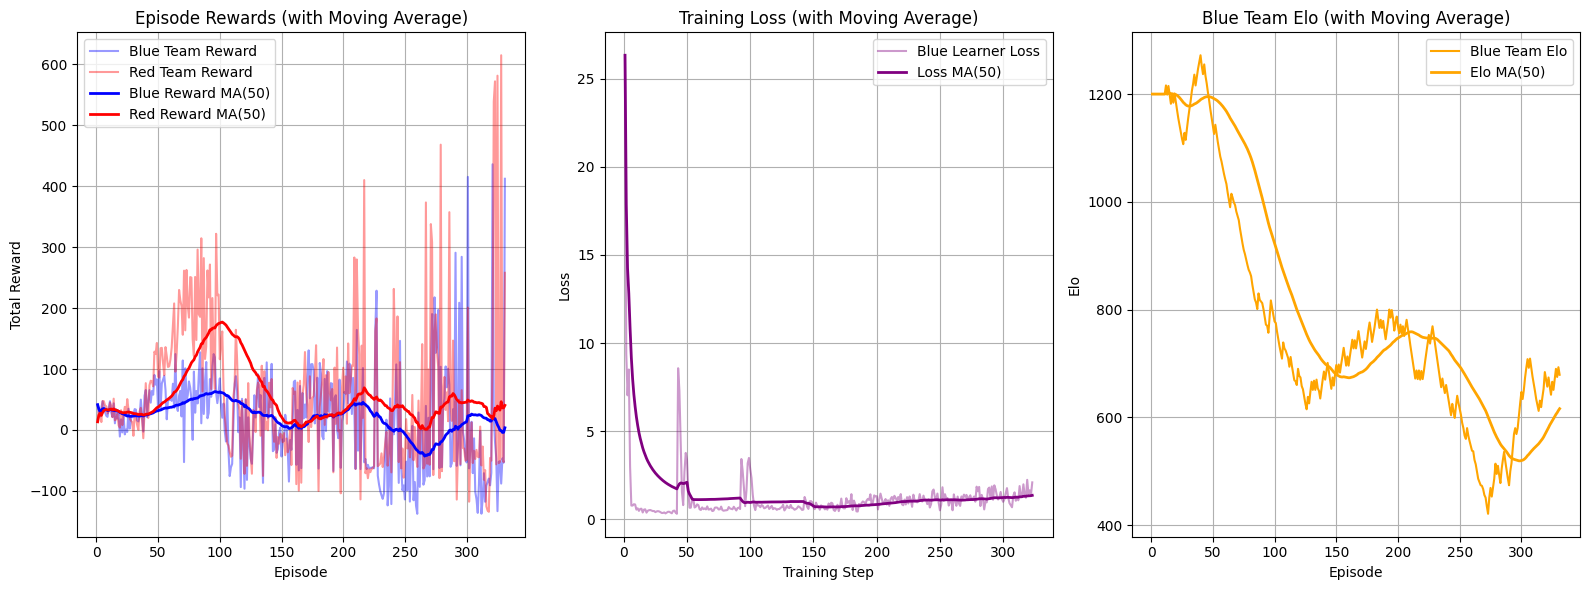

In [9]:
import pandas as pd
import torch
import numpy as np
import random
import os
import matplotlib.pyplot as plt

# Assuming MAgent2 is installed and accessible
from magent2.environments import battle_v4


config = Config()
set_seeds(config.SEED)
os.makedirs(config.MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(config.LOG_DIR, exist_ok=True)

print(f"Using device: {config.DEVICE}")
if config.DEVICE == "cuda":
    print(f"Number of CUDA devices available: {torch.cuda.device_count()}")

print(f"Training team (Blue): {config.TRAIN_TEAM_PREFIX}")
print(f"Opponent team (Red): {config.OPPONENT_TEAM_PREFIX}")

# --- Initialize Environment ---
env_config_copy = config.ENV_CONFIG.copy()
env = battle_v4.parallel_env(**env_config_copy)
try:
    env.reset(seed=config.SEED)
except TypeError:
    print("Warning: env.reset() does not accept a seed argument. Global seeds will be used.")
    env.reset()

# --- Get Agent and Environment Details ---
blue_team_agent_ids = sorted([agent_id for agent_id in env.agents if agent_id.startswith(config.TRAIN_TEAM_PREFIX)])
red_team_agent_ids = sorted([agent_id for agent_id in env.agents if agent_id.startswith(config.OPPONENT_TEAM_PREFIX)])

if not blue_team_agent_ids:
    raise ValueError(f"No agents found for Blue team with prefix: {config.TRAIN_TEAM_PREFIX}")
if not red_team_agent_ids:
    raise ValueError(f"No agents found for Red team with prefix: {config.OPPONENT_TEAM_PREFIX}")

n_agents_blue_team = len(blue_team_agent_ids)
n_agents_red_team = len(red_team_agent_ids)
print(f"Number of agents in Blue team: {n_agents_blue_team}")
print(f"Number of agents in Red team: {n_agents_red_team}")

first_blue_agent_id = blue_team_agent_ids[0]
obs_shape_blue_agent = env.observation_space(first_blue_agent_id).shape
action_shape_blue_agent = env.action_space(first_blue_agent_id).n

first_red_agent_id = red_team_agent_ids[0]
obs_shape_red_agent = env.observation_space(first_red_agent_id).shape
action_shape_red_agent = env.action_space(first_red_agent_id).n

global_state_shape_tuple = env.state().shape
global_state_shape_flat = int(np.prod(global_state_shape_tuple))

print(f"Blue Agent Observation Shape: {obs_shape_blue_agent}")
print(f"Blue Agent Action Shape (Number of actions): {action_shape_blue_agent}")
print(f"Red Agent Observation Shape: {obs_shape_red_agent}")
print(f"Red Agent Action Shape: {action_shape_red_agent}")
print(f"Global State Shape (raw tuple for buffer): {global_state_shape_tuple}")
print(f"Global State Shape (flattened for mixer): {global_state_shape_flat}")

# --- Initialize Learners and Buffers for Both Teams ---
print("Initializing a QMIX learner for the Blue team.")
blue_learner = QMIXLearner(
    n_agents=n_agents_blue_team,
    obs_shape=obs_shape_blue_agent,
    state_shape=global_state_shape_flat,
    n_actions=action_shape_blue_agent,
    args=config
)

episode_buffer_blue = EpisodeBuffer(
    buffer_size_episodes=config.MAX_BUFFER_SIZE_EPISODES,
    episode_len_limit=config.ENV_CONFIG["max_cycles"],
    n_agents=n_agents_blue_team,
    obs_shape=obs_shape_blue_agent,
    state_shape=global_state_shape_tuple,
    action_shape=1,
    device=config.DEVICE
)

episode_rewards_history_blue = []
episode_rewards_history_red = []
episode_losses_history = []
blue_elo_history = []

total_steps_counter = 0
completed_episodes_counter = 0

# --- Start try block for training ---
try:
    print(f"Starting training for {config.NUM_EPISODES_TOTAL} episodes with a learner for the Blue team...")

    elo_manager_registry_file = os.path.join(config.MODEL_SAVE_DIR, "elo_pool_registry.json")
    elo_manager_models_dir = os.path.join(config.MODEL_SAVE_DIR, "elo_opponent_models_storage")

    elo_manager = EloManager(
        pool_registry_file=elo_manager_registry_file,
        max_pool_size=config.OPPONENT_POOL_MAX_SIZE,
        opponent_models_storage_dir=elo_manager_models_dir
    )
    current_blue_team_elo = config.DEFAULT_ELO

    # Prepare opponent agent net for loading policies
    opponent_agent_net = RNNAgent(
        input_shape=obs_shape_red_agent,
        n_actions=action_shape_red_agent,
        rnn_hidden_dim=config.RNN_HIDDEN_DIM
    ).to(config.DEVICE)

    opponent_using_data_parallel = False # Flag to track if opponent_agent_net is using DataParallel
    if config.DEVICE == "cuda" and torch.cuda.device_count() > 1:
        print(f"Using DataParallel for Opponent RNNAgent across {torch.cuda.device_count()} GPUs.")
        opponent_agent_net = nn.DataParallel(opponent_agent_net)
        opponent_using_data_parallel = True
    opponent_agent_net.eval()

    # Initialize hidden state for Red team's opponent network (will be updated when policy loads)
    if opponent_using_data_parallel:
        current_red_team_hidden_states = opponent_agent_net.module.init_hidden().squeeze(0).repeat(n_agents_red_team, 1).cpu().numpy()
    else:
        current_red_team_hidden_states = opponent_agent_net.init_hidden().squeeze(0).repeat(n_agents_red_team, 1).cpu().numpy()    
    for i_episode in range(config.NUM_EPISODES_TOTAL):
        print(f"======== Episode {i_episode+1} of {config.NUM_EPISODES_TOTAL} =========")
        episode_buffer_blue.start_new_episode()
        obs_dict = env.reset()

        if blue_learner.using_data_parallel:
            current_blue_team_hidden_states = blue_learner.policy_agent_net.module.init_hidden().squeeze(0).repeat(n_agents_blue_team, 1).cpu().numpy()
        else:
            current_blue_team_hidden_states = blue_learner.policy_agent_net.init_hidden().squeeze(0).repeat(n_agents_blue_team, 1).cpu().numpy()
        
        # current_red_team_hidden_states will be re-initialized below if a new opponent is loaded

        current_episode_total_reward_blue = 0
        current_episode_total_reward_red = 0
        current_episode_steps = 0
        terminated_episode = False
        current_red_team_opponent_obj = None

        # Opponent selection for Red team
        needs_new_opponent = (i_episode == 0) or \
                                (i_episode > 0 and i_episode % config.OPPONENT_SWITCH_INTERVAL_EPISODES == 0) or \
                                (current_red_team_opponent_obj is None and len(elo_manager.opponent_pool) > 0)

        if needs_new_opponent:
            selected_opponent_obj = elo_manager.select_opponent(
                current_agent_elo=current_blue_team_elo,
                strategy=config.OPPONENT_SELECTION_STRATEGY
            )
            if selected_opponent_obj:
                print(f"Red team loading opponent with Elo: {selected_opponent_obj.elo}")
                try:
                    # state_dict_from_file is clean (no "module." prefix)
                    state_dict_from_file = torch.load(selected_opponent_obj.policy_path, map_location=config.DEVICE)
                    if opponent_using_data_parallel:
                        opponent_agent_net.module.load_state_dict(state_dict_from_file)
                    else:
                        opponent_agent_net.load_state_dict(state_dict_from_file)
                    current_red_team_opponent_obj = selected_opponent_obj
                except Exception as e:
                    print(f"Error loading opponent policy {selected_opponent_obj.policy_path}: {e}. Red using Blue's current policy as fallback.")
                    if blue_learner.using_data_parallel:
                        state_dict_to_load = blue_learner.policy_agent_net.module.state_dict()
                    else:
                        state_dict_to_load = blue_learner.policy_agent_net.state_dict()
                    
                    # Load the clean state_dict_to_load appropriately
                    if opponent_using_data_parallel:
                        opponent_agent_net.module.load_state_dict(state_dict_to_load)
                    else:
                        opponent_agent_net.load_state_dict(state_dict_to_load)
                    current_red_team_opponent_obj = None # Fallback is not an Elo pool opponent
            else:
                print("No opponent selected from Elo pool or pool empty. Red team uses copy of Blue's current policy.")
                if blue_learner.using_data_parallel:
                    state_dict_to_load = blue_learner.policy_agent_net.module.state_dict()
                else:
                    state_dict_to_load = blue_learner.policy_agent_net.state_dict()
                
                # Load the clean state_dict_to_load appropriately
                if opponent_using_data_parallel:
                    opponent_agent_net.module.load_state_dict(state_dict_to_load)
                else:
                    opponent_agent_net.load_state_dict(state_dict_to_load)
                current_red_team_opponent_obj = None

            # IMPORTANT: Re-initialize hidden state for the newly loaded policy in opponent_agent_net
            if opponent_using_data_parallel:
                current_red_team_hidden_states = opponent_agent_net.module.init_hidden().squeeze(0).repeat(n_agents_red_team, 1).cpu().numpy()
            else:
                current_red_team_hidden_states = opponent_agent_net.init_hidden().squeeze(0).repeat(n_agents_red_team, 1).cpu().numpy()
            opponent_agent_net.eval()

        for step_in_episode in range(config.ENV_CONFIG["max_cycles"]):
            if config.ENV_CONFIG.get("render_mode") == "human":
                env.render()

            # Get current global state (s_t) *before* taking an action
            current_global_state_s_t = env.state()

            # --- Action Selection for Blue Team ---
            blue_team_obs_list = [obs_dict.get(agent_id, np.zeros(obs_shape_blue_agent, dtype=np.float32)) for agent_id in blue_team_agent_ids]
            blue_team_obs_np = np.array(blue_team_obs_list)
            q_vals_blue_team, next_hidden_states_blue_team_np = blue_learner.get_policy_agent_q_values(
                blue_team_obs_np, current_blue_team_hidden_states
            )
            epsilon_blue = linear_epsilon(completed_episodes_counter, config.EPS_START, config.EPS_END, config.EPS_DECAY_EPISODES)
            blue_team_actions = [
                random.randint(0, action_shape_blue_agent - 1) if random.random() < epsilon_blue else np.argmax(q_vals_blue_team[i])
                for i in range(n_agents_blue_team)
            ]

            # --- Action Selection for Red Team ---
            red_team_obs_list = [obs_dict.get(agent_id, np.zeros(obs_shape_red_agent, dtype=np.float32)) for agent_id in red_team_agent_ids]
            red_team_obs_np = np.array(red_team_obs_list)

            # Convert to tensors for opponent_agent_net
            red_team_obs_tensor = torch.tensor(red_team_obs_np, dtype=torch.float32).to(config.DEVICE)
            red_team_hidden_tensor = torch.tensor(current_red_team_hidden_states, dtype=torch.float32).to(config.DEVICE)

            # Get Q-values from opponent_agent_net (which has the loaded policy)
            with torch.no_grad():
                q_vals_red_team_tensor, next_hidden_states_red_team_tensor = opponent_agent_net(
                    red_team_obs_tensor, red_team_hidden_tensor
                )
            q_vals_red_team_numpy = q_vals_red_team_tensor.cpu().numpy()
            next_hidden_states_red_team_np = next_hidden_states_red_team_tensor.cpu().numpy()

            epsilon_red = linear_epsilon(
                completed_episodes_counter,
                config.RED_EPS_START,
                config.RED_EPS_END,
                config.RED_EPS_DECAY_EPISODES
            )
            red_team_actions = [
                random.randint(0, action_shape_red_agent - 1) if random.random() < epsilon_red else np.argmax(q_vals_red_team_numpy[i])
                for i in range(n_agents_red_team)
            ]

            # --- Combine actions and Step Environment ---
            actions_to_env = {}
            for i, agent_id in enumerate(blue_team_agent_ids):
                if agent_id in obs_dict: actions_to_env[agent_id] = blue_team_actions[i]
            for i, agent_id in enumerate(red_team_agent_ids):
                if agent_id in obs_dict: actions_to_env[agent_id] = red_team_actions[i]

            next_obs_dict, rewards_dict, dones_dict, truncs_dict, infos_dict = env.step(actions_to_env)

            global_reward_blue = sum(rewards_dict.get(agent_id, 0) for agent_id in blue_team_agent_ids)
            global_reward_red = sum(rewards_dict.get(agent_id, 0) for agent_id in red_team_agent_ids)

            current_episode_total_reward_blue += global_reward_blue
            current_episode_total_reward_red += global_reward_red

            # terminated_episode_flag is True if s_{t+1} is a true terminal state
            terminated_episode_flag = dones_dict.get("__all__", False)
            # truncated_episode_flag is True if s_{t+1} is a truncated state (e.g., time limit)
            truncated_episode_flag = truncs_dict.get("__all__", False)
            
            # Episode ends if it's a true termination OR a truncation
            episode_actually_over = terminated_episode_flag or truncated_episode_flag

            # --- Store Transition in Buffer for Blue Team ---
            # obs_n: o_t (observations at current step t)
            # state: s_t (global state at current step t)
            # actions: u_t (actions taken at current step t)
            # reward: r_t (reward received after u_t)
            # terminated: True if s_{t+1} (next state) is a true terminal state (not truncated)
            blue_actions_np_reshaped = np.array(blue_team_actions).reshape(n_agents_blue_team, 1)
            episode_buffer_blue.add_transition(
                obs_n=blue_team_obs_np,
                state=current_global_state_s_t, # Pass s_t
                actions=blue_actions_np_reshaped,
                reward=global_reward_blue,
                terminated=terminated_episode_flag # Pass only true termination flag
            )

            # Store Red team's transition in the same buffer (if needed, adjust for s_t and terminated flag)
            # Assuming red_team_obs_np is o_t for red, and we need s_t (which is current_global_state_s_t)
            # and terminated_episode_flag applies to the whole environment state.
            red_actions_np_reshaped = np.array(red_team_actions).reshape(n_agents_red_team, 1)
            episode_buffer_blue.add_transition(
                obs_n=red_team_obs_np, # o_t for red
                state=current_global_state_s_t, # s_t (same global state)
                actions=red_actions_np_reshaped, # u_t for red
                reward=global_reward_red, # r_t for red
                terminated=terminated_episode_flag # True if s_{t+1} is terminal
            )

            obs_dict = next_obs_dict
            current_blue_team_hidden_states = next_hidden_states_blue_team_np
            current_red_team_hidden_states = next_hidden_states_red_team_np

            total_steps_counter += 1
            current_episode_steps += 1

            if episode_actually_over:
                break

        # --- End of Episode ---
        completed_episodes_counter += 1
        episode_rewards_history_blue.append(current_episode_total_reward_blue)
        episode_rewards_history_red.append(current_episode_total_reward_red)
        blue_elo_history.append(current_blue_team_elo)

        # --- Learning Update ---
        if completed_episodes_counter % config.TRAIN_INTERVAL_EPISODES == 0:
            if completed_episodes_counter >= config.MIN_EPISODES_FOR_TRAINING:
                can_train_blue = len(episode_buffer_blue) >= config.BATCH_SIZE_EPISODES

                if can_train_blue:
                    # print(f"Training at episode {completed_episodes_counter}")
                    batch_blue = episode_buffer_blue.sample_batch(config.BATCH_SIZE_EPISODES)
                    if batch_blue is not None and batch_blue["obs"].shape[1] > 0:
                        loss_b = blue_learner.train(batch_blue, completed_episodes_counter)
                        if loss_b is not None:
                            episode_losses_history.append(loss_b)
                        # print(f"Completed training for Blue team at episode {completed_episodes_counter}")
                    else:
                        print(f"Skipping training for Blue team at episode {completed_episodes_counter}: batch invalid or empty.")
                else:
                    print(f"Skipping training at episode {completed_episodes_counter}: Blue buffer not ready ({len(episode_buffer_blue)}/{config.BATCH_SIZE_EPISODES}).")
            else:
                print(f"Skipping training at episode {completed_episodes_counter}: min episodes ({config.MIN_EPISODES_FOR_TRAINING}) not reached.")

        # --- Logging ---
        if (i_episode + 1) % config.LOG_INTERVAL_EPISODES == 0:
            avg_reward_blue = np.mean(episode_rewards_history_blue[-config.LOG_INTERVAL_EPISODES:]) if episode_rewards_history_blue else 0
            avg_loss_blue = episode_losses_history[-1] if episode_losses_history else 0
            avg_reward_red = np.mean(episode_rewards_history_red[-config.LOG_INTERVAL_EPISODES:]) if episode_rewards_history_red else 0

            print(f"Episode: {i_episode+1}/{config.NUM_EPISODES_TOTAL} | Steps: {total_steps_counter}")
            print(f"  Blue Team - Avg Reward: {avg_reward_blue:.2f}, Epsilon: {epsilon_blue:.2f}")
            print(f"  Red Team  - Avg Reward: {avg_reward_red:.2f}, Epsilon: {epsilon_red:.2f}")
            print(f"  Blue Learner - Avg Loss: {avg_loss_blue:.4f}")

        # --- Model Saving and Elo Pool Update ---
        if (i_episode + 1) % config.MODEL_SAVE_INTERVAL_EPISODES == 0:
            model_path_prefix = os.path.join(config.MODEL_SAVE_DIR, f"qmix_blue_ep{i_episode+1}")
            blue_learner.save_models(model_path_prefix)
            # print(f"Saved Blue learner model components at {model_path_prefix}")

            # Path to the agent model file specifically for the Elo pool
            agent_model_path_for_elo = f"{model_path_prefix}_agent.pt"

            if os.path.exists(agent_model_path_for_elo):
                snapshot_name = f"blue_ep{i_episode+1}_elo{current_blue_team_elo:.0f}"
                elo_manager.add_opponent_to_pool(
                    source_policy_path=agent_model_path_for_elo,
                    initial_elo=current_blue_team_elo,
                    name_prefix=snapshot_name
                )
            else:
                print(f"Warning: Agent model {agent_model_path_for_elo} not found after saving. Cannot add to Elo pool.")

        # --- Elo Update ---
        if current_red_team_opponent_obj:
            score_for_blue = 0.5
            if current_episode_total_reward_blue > current_episode_total_reward_red:
                score_for_blue = 1.0
            elif current_episode_total_reward_red > current_episode_total_reward_blue:
                score_for_blue = 0.0

            opponent_elo_before_match = current_red_team_opponent_obj.elo
            new_blue_elo, new_opponent_elo = update_elo_ratings(
                current_blue_team_elo,
                opponent_elo_before_match,
                score_for_blue,
                k_factor=config.ELO_K_FACTOR
            )

            print(f"Elo Update after Ep {i_episode+1}: Blue ({current_blue_team_elo:.0f}->{new_blue_elo:.0f}) vs "
                    f"Red ({opponent_elo_before_match:.0f}->{new_opponent_elo:.0f}). \n"
                    f"Blue score: {score_for_blue}. Blue Reward: {current_episode_total_reward_blue:.2f}, Red Reward: {current_episode_total_reward_red:.2f}")

            current_blue_team_elo = new_blue_elo
            elo_manager.update_opponent_stats(current_red_team_opponent_obj.name, new_opponent_elo)
        else:
            print(f"Ep {i_episode+1}: Blue Reward: {current_episode_total_reward_blue:.2f}, Red Reward (non-Elo opponent): {current_episode_total_reward_red:.2f}. No Elo update.")

        print(f"=====================================================\n")

    # --- End of Training ---
    env.close()
    print("Training finished.")

except Exception as e:
    print(f"Exception occurred during training: {e}")
    import traceback
    traceback.print_exc()
finally:
    # --- Plotting ---
    plt.figure(figsize=(16, 6))

    # --- Plot Rewards ---
    plt.subplot(1, 3, 1)
    episodes = np.arange(1, len(episode_rewards_history_blue) + 1)
    plt.plot(episodes, episode_rewards_history_blue, label="Blue Team Reward", color='blue', alpha=0.4)
    plt.plot(episodes, episode_rewards_history_red, label="Red Team Reward", color='red', alpha=0.4)

    # Moving average for rewards
    window = min(50, len(episodes))
    if window > 1:
        blue_ma = pd.Series(episode_rewards_history_blue).rolling(window, min_periods=1).mean()
        red_ma = pd.Series(episode_rewards_history_red).rolling(window, min_periods=1).mean()
        plt.plot(episodes, blue_ma, label=f"Blue Reward MA({window})", color='blue', linewidth=2)
        plt.plot(episodes, red_ma, label=f"Red Reward MA({window})", color='red', linewidth=2)

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Episode Rewards (with Moving Average)")
    plt.legend()
    plt.grid(True)

    # --- Plot Loss ---
    plt.subplot(1, 3, 2)
    if episode_losses_history:
        steps = np.arange(1, len(episode_losses_history) + 1)
        plt.plot(steps, episode_losses_history, label="Blue Learner Loss", color='purple', alpha=0.4)
        # Moving average for loss
        window_loss = min(50, len(steps))
        if window_loss > 1:
            loss_ma = pd.Series(episode_losses_history).rolling(window_loss, min_periods=1).mean()
            plt.plot(steps, loss_ma, label=f"Loss MA({window_loss})", color='purple', linewidth=2)
        plt.xlabel("Training Step")
        plt.ylabel("Loss")
        plt.title("Training Loss (with Moving Average)")
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, "No loss data", ha='center', va='center')
        plt.axis('off')

    # --- Plot Blue Team Elo ---
    plt.subplot(1, 3, 3)
    if blue_elo_history:
        plt.plot(episodes, blue_elo_history, label="Blue Team Elo", color='orange')
        # Moving average for Elo
        window_elo = min(50, len(episodes))
        if window_elo > 1:
            elo_ma = pd.Series(blue_elo_history).rolling(window_elo, min_periods=1).mean()
            plt.plot(episodes, elo_ma, label=f"Elo MA({window_elo})", color='orange', linewidth=2)
        plt.xlabel("Episode")
        plt.ylabel("Elo")
        plt.title("Blue Team Elo (with Moving Average)")
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, "No Elo data", ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(config.LOG_DIR, "training_summary.png"))
    plt.show()